In [1]:
# Импортирование библоитек
import pandas as pd 
import numpy as np
from numpy import asarray
from itertools import tee
from pathlib import Path
import cv2, pickle, csv, os, sys, re, math, inspect
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class AugmentApply():
    
    def __init__(self, list_of_methods):
        
        self.list_of_methods = list_of_methods
        
        for method in list_of_methods:
            if not inspect.isclass(method.__class__):
                raise ValueError("Ошибка! Проверь правописание методов.")
                        
        print("Просто жди...")
        for method in list_of_methods:
            method.apply_me()
        print("Готово!")
    
    
class RotateImages():
    
    def __init__(self, angle):
        assert type(angle) == int, "Должно быть целое число!"
        self.angle = int(angle)
    
    def apply_me(self):
        print("Применение вращения изображении на " + str(self.angle) + " градусов")
        rotateCSVfile(self.angle)
        rotateImage(self.angle)      
    
    
class MirrorImages():
    def __init__(self, ):
        pass
    
    def apply_me(self):
        pass # AUGMENTING HERE!

    
class FlipImages():
    
    def __init__(self, ):
        pass
    
    def apply_me(self):
        pass # AUGMENTING HERE!

    
class ShiftImages():
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def apply_me(self):
        pass # AUGMENTING HERE!


In [3]:
# Функции для просмотра изображении
def string2image(jpeg_image_path):
    image = Image.open(jpeg_image_path)
    img_array = np.asarray(image)
    return img_array
    
    
def plot_cow(image):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(string2image(image), cmap='gray')
    
    
def rotatePoint(centerPoint, point, angle):
    """ Функция для вращения точки относительно другой точки(в данном случае, центра картинки) """
    angle = math.radians(-angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point


# Создание и сохранение перевернутых изображении
def rotateImage(angle):
    global curr_img_count
    """ Функция для вращения изображении """
    for image_name in sorted_images:
        image = cv2.imread(os.path.join(images_dirname, image_name))
        height, width = image.shape[:2]
        center = (width/2, height/2)
        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=15, scale=1)
        rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
        os.chdir(images_dirname)
        cv2.imwrite("cow" + str(curr_img_count+1) +'.jpg', rotated_image)
        curr_img_count += 1
    os.chdir(current_wd)
    

def rotateCSVfile(angle):
    
    height, width = SHAPE[:2]
    center = (width/2, height/2)
    rot_keypoints_df = keypoints_df.copy()

    for row in range(len(rot_keypoints_df.index)):
        rot_keypoints_df.iat[row, 1] = "cow" + str(globals()["last_image_index"]+1) + ".jpg"
        rot_keypoints_df.iat[row, 0] = globals()["last_image_index"] + 1
        
        globals()["last_image_index"] += 1
        for pair in pairwise_2(range(len(rot_keypoints_df.columns[2:]))):
            point_x = rot_keypoints_df.iloc[row,2:][pair[0]]
            point_y = rot_keypoints_df.iloc[row,2:][pair[1]]
            new_points = rotatePoint(center, (point_x, point_y), angle)
            if new_points[0] < 0 or new_points[1] < 0 or new_points[0] > width or new_points[1] > height:
                rot_keypoints_df.iat[row,pair[0]+2] = 0
                rot_keypoints_df.iat[row,pair[1]+2] = 0
            else:
                rot_keypoints_df.iat[row,pair[0]+2] = new_points[0]
                rot_keypoints_df.iat[row,pair[1]+2] = new_points[1]
    
    with open(csv_file_path, "a", newline='') as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for row in rot_keypoints_df.values.tolist():
            writer.writerow(row)
        
        
# Функция для специальной парной итерации
def pairwise_2(iterable):
    a = iter(iterable)
    return zip(a, a)

In [4]:
# Чтение таблицы ключевых точек и директории изображении. Указать путь к CSV файлу и изображениям.
csv_file_path = Path(r"C:\Users\Sony\Desktop\Data Augmentation\test\test_dataset.csv")
images_dirname = Path(r"C:\Users\Sony\Desktop\Data Augmentation\test\colored") 
keypoints_df = pd.read_csv(csv_file_path)

images_ext = re.compile(".*(.jpg|.jpeg)")

filtered = list(filter(images_ext.match, os.listdir(images_dirname)))
try:
    sorted_images = sorted(filtered ,key=lambda x: int(os.path.splitext(x)[0][3:]))
except:
    try:
        sorted_images = sorted(filtered ,key=lambda x: int(os.path.splitext(x)[0][2:]))
    except:
        sorted_images = sorted(filtered)

In [5]:
# Получение разрешения входных изображении (ширина, высота, кол.каналов)
image = Image.open(Path(os.path.join(images_dirname, sorted_images[0])))
img_array = np.asarray(image)
SHAPE = (image.size[1], image.size[0], image.layers)
last_image_index = len(sorted_images) - 1
curr_img_count = len(sorted_images) - 1
current_wd = os.getcwd()

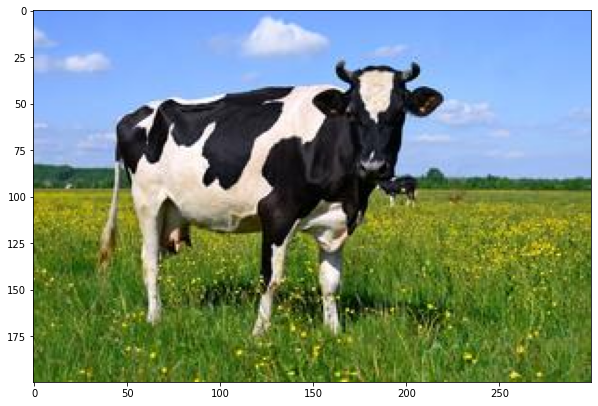

In [6]:
# Просмотр одного изображения по номеру(индексу)         
plot_cow(Path(os.path.join(images_dirname, sorted_images[0])))

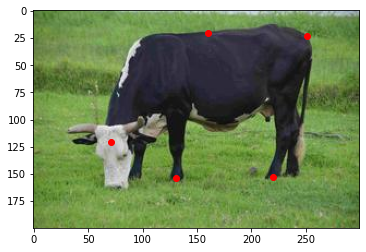

In [7]:
# Просмотр изображении с аннотациями по номеру.
image_index = 5
keypoint_cols = list(keypoints_df.columns)[2:]
xy = keypoints_df.iloc[image_index][keypoint_cols].values.reshape((int(len(keypoints_df.columns[2:])/2), 2))
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(Path(os.path.join(images_dirname, sorted_images[image_index]))), cmap='gray')

In [8]:
#                             !!! АУГМЕНТАЦИЯ ДАННЫХ !!!

In [9]:
# Каскад увеличения данных 
data_augment = [
    RotateImages(15),
#     MirrorImages(),
#     FlipImages(),
#     ShiftImages(x, y),
]
AugmentApply(data_augment)

Just wait a bit, please...
Yeah, finished! Go on.


In [10]:
keypoints_df = pd.read_csv(csv_file_path)

images_ext = re.compile(".*(.jpg|.jpeg)")

filtered = list(filter(images_ext.match, os.listdir(images_dirname)))
try:
    sorted_images = sorted(filtered ,key=lambda x: int(os.path.splitext(x)[0][3:]))
except:
    try:
        sorted_images = sorted(filtered ,key=lambda x: int(os.path.splitext(x)[0][2:]))
    except:
        sorted_images = sorted(filtered)

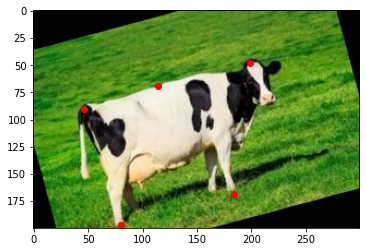

In [13]:
# Просмотр изображении с аннотациями по номеру.
image_index = 17
keypoint_cols = list(keypoints_df.columns)[2:]
xy = keypoints_df.iloc[image_index][keypoint_cols].values.reshape((int(len(keypoints_df.columns[2:])/2), 2))
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(Path(os.path.join(images_dirname, sorted_images[image_index]))), cmap='gray')